https://www.uplift-modeling.com/en/latest/tutorials.html

### Домашнее задание 4 урок

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных на тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Описание датасета

#### Context
Marketing Promotion Campaign
with a total of 6,400 customers data.

#### Content
This dataset show customer's brief information,
historical use of discount or BOGO(Buy One Get One) promotion,
offer has been made, and the conversion result(buy or not).
The conversion average value = $25

####Acknowledgements
This dataset is a fictional dataset for practicing purpose

####Inspiration
Predict customer's conversion rate
Uplift Modelling to maximizing marketing campaign and reducing campaign cost

####Features
**recency** - months since last purchase<br>
**history** - $value of the historical purchases<br>
**used_discount** - indicates if the customer used a discount before<br>
**used_bogo** - indicates if the customer used a buy one get one before<br>
**zip_code** - class of the zip code as Suburban/Urban/Rural<br>
**is_referral** - indicates if the customer was acquired from referral channel<br>
**channel** - channels that the customer using, Phone/Web/Multichannel<br>
**offer** - the offers sent to the customers, Discount/But One Get One/No Offer<br>
**conversion** - customer conversion(buy or not)

### Подготовка к работе

#### Импортируем нужные библиотеки и предобработаем данные:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-uplift==0.2.0

In [3]:
!pip install catboost

     |████████████████████████████████| 67.3MB 60kB/s 


In [4]:
# !git clone https://github.com/uber/causalml.git
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install

In [5]:
!pip install causalml

     |████████████████████████████████| 245kB 5.4MB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 327kB 45.7MB/s 
     |████████████████████████████████| 1.8MB 43.0MB/s 
     |████████████████████████████████| 634kB 46.0MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493678 sha256=356ad90f74422b6c8b81a5ddcbc224deca66109649b4609320d8e1b1e363ce5e
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465045 sha256=a4be52b8ece6aae47fa638dd6b2ec1bb8a63f94561c28fc100034ef81b998914
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement

In [6]:
!apt install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [33]:
%matplotlib inline

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k, uplift_by_percentile, uplift_auc_score, qini_auc_score
from sklift.viz import plot_uplift_preds, plot_uplift_by_percentile, plot_uplift_curve, plot_qini_curve
from sklift.models import SoloModel, ClassTransformation, TwoModels

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
import graphviz

In [8]:
# Чтение данных
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/machine_learning_in_business/4/hw_data.csv")
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Переименуем поля (conversion -> target, offer -> treatment) и приведем поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [10]:
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


#### Feature Engineering

In [11]:
# Был ли предлагаемый оффер использован ранее?
df.loc[(df['treatment'] == 'Buy One Get One') & (df['used_bogo'] == 1), 'was_offer_used'] = 'used'
df.loc[(df['treatment'] == 'Discount') & (df['used_discount'] == 1), 'was_offer_used'] = 'used'
df.loc[(df['used_bogo'] == 0) & (df['used_discount'] == 0), 'was_offer_used'] = 'never_saw_an_offer'
df.loc[df['was_offer_used'].isna(), 'was_offer_used'] = 'not_used'
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,was_offer_used
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,not_used
1,6,329.08,1,1,Rural,1,Web,No Offer,0,not_used
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,used
3,9,675.83,1,0,Rural,1,Web,Discount,0,used
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,not_used


In [12]:
median_history_purchases_on_zip_code = df.groupby(['zip_code'], as_index=False).agg({'history':'median'})\
                       .rename(columns={'history':'median_history_purchases_on_zip_code'})
df = df.merge(median_history_purchases_on_zip_code, on='zip_code', how='left')

median_history_purchases_on_zip_code

,zip_code,median_history_purchases_on_zip_code
0,Rural,159.58
1,Surburban,155.52
2,Urban,160.28


In [13]:
median_history_purchases_on_offer_used = df.groupby(['was_offer_used'], as_index=False).agg({'history':'median'})\
                       .rename(columns={'history':'median_history_purchases_on_offer_used'})
df = df.merge(median_history_purchases_on_offer_used, on='was_offer_used', how='left')

median_history_purchases_on_offer_used

,was_offer_used,median_history_purchases_on_offer_used
0,not_used,146.115
1,used,183.845


In [14]:
df['history_on_recency_duration'] = df['history'] / df['recency']

In [15]:
# В конце заменим 'treatment' на 1 и 0 соответственно, в зависимости от того, было воздействие или нет.
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

df.groupby(["treatment", "target"], as_index=False).agg({'channel':'count'})\
                       .rename(columns={'channel':'count'})

,treatment,target,count
0,0,0,19044
1,0,1,2262
2,1,0,35562
3,1,1,7132


In [16]:
df['treatment'] = df['treatment'].astype(str).astype(int)

In [17]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,was_offer_used,median_history_purchases_on_zip_code,median_history_purchases_on_offer_used,history_on_recency_duration
0,10,142.44,1,0,Surburban,0,Phone,1,0,not_used,155.52,146.115,14.244000
1,6,329.08,1,1,Rural,1,Web,0,0,not_used,159.58,146.115,54.846667
2,7,180.65,0,1,Surburban,1,Web,1,0,used,155.52,183.845,25.807143
3,9,675.83,1,0,Rural,1,Web,1,0,used,159.58,183.845,75.092222
4,2,45.34,1,0,Urban,0,Web,1,0,not_used,160.28,146.115,22.670000


#### Сделаем разбиение набора данных не тренировочную и тестовую выборки.

In [18]:
y = df["target"]
X = df.drop(columns=["target"])
X_train_draft, X_test_draft, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.25, random_state=42)

In [19]:
X_train = X_train_draft.drop(columns=["treatment"])
treat_train = X_train_draft['treatment']

X_test = X_test_draft.drop(columns=["treatment"])
treat_test = X_test_draft['treatment']

cat_features = ['zip_code', 'channel', 'was_offer_used']

models_results = {
    'approach': [],
    'uplift@10%': [], 
    'uplift@20%': [],
    'uplift@30%': []  # Это значит топ-30% юзеров с самым большим значением метрики uplift
}

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

uplift@10%: 0.0577, uplift@20%: 0.0480, uplift@30%: 0.0737


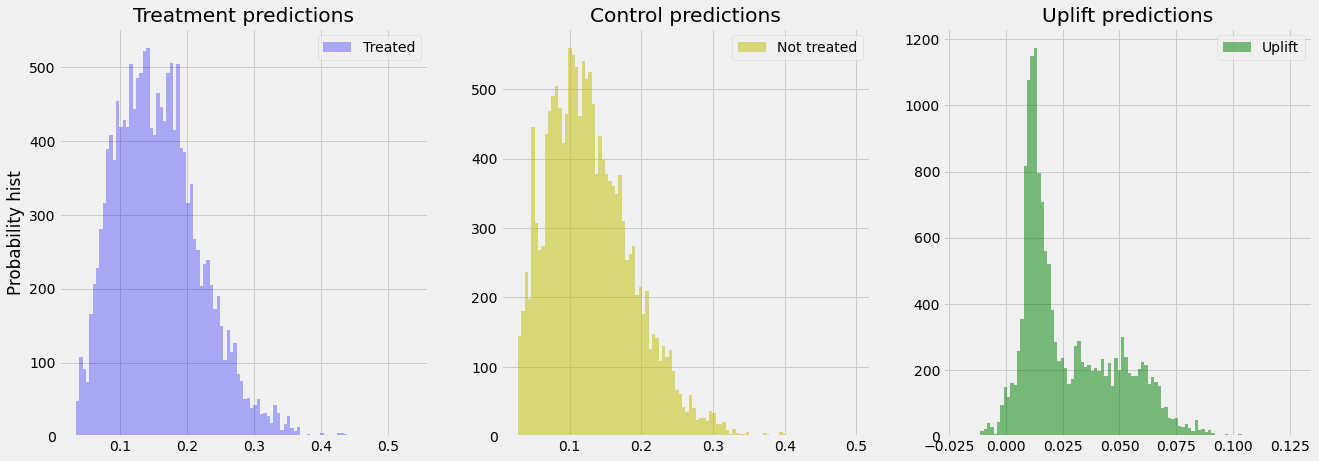

In [20]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@10%: {sm_score_10:.4f}, uplift@20%: {sm_score_20:.4f}, uplift@30%: {sm_score_30:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [21]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,16.448675
1,median_history_purchases_on_zip_code,13.915286
2,treatment,9.844660
3,median_history_purchases_on_offer_used,9.656268
4,used_discount,8.027786
5,channel,7.986898
6,used_bogo,7.153546
7,history,6.751136
8,history_on_recency_duration,6.729002
9,was_offer_used,6.304874


**Uplift by percentile**

Метрики: https://habr.com/ru/company/ru_mts/blog/538934/

https://nbviewer.jupyter.org/github/maks-sh/scikit-uplift/blob/master/notebooks/uplift_metrics_tutorial.ipynb

In [22]:
uplift_by_percentile(y_test, uplift_sm, treat_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
10.0,801,799,0.197253,0.132666,0.064588,0.014060,0.012001,0.018485
20.0,842,758,0.180523,0.094987,0.085536,0.013255,0.010649,0.017003
30.0,1029,571,0.173955,0.071804,0.102151,0.011817,0.010804,0.016011
40.0,1232,368,0.215097,0.084239,0.130858,0.011706,0.014479,0.018619
50.0,1275,325,0.200000,0.187692,0.012308,0.011202,0.021659,0.024385
60.0,1207,393,0.181442,0.185751,-0.004309,0.011093,0.019618,0.022537
70.0,1010,590,0.135644,0.100000,0.035644,0.010774,0.012351,0.016390
80.0,1013,587,0.128332,0.090290,0.038042,0.010508,0.011829,0.015823
90.0,1086,514,0.107735,0.071984,0.035750,0.009408,0.011400,0.014781


**График uplift by percentile**

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


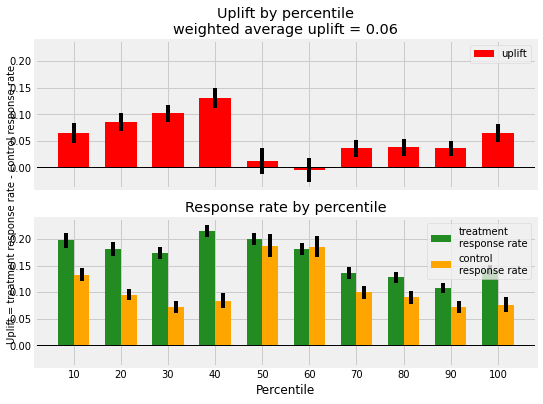

In [24]:
plot_uplift_by_percentile(y_test, uplift_sm, treat_test, strategy='overall', kind='bar');

В идеале на графике response rate для целевой и контрольной группы (нижний bar plot) доля реакций клиентов Y = 1 из целевой группы (зеленый цвет) должна быть максимально большой в первых перцентилях и потом убывать. А доля Y = 1 контрольной группы (желтый цвет) - минимальной в первых перцентилях и затем, в идеале, возрастать. Чем больше в первых перцентилях разница двух response rate, тем больше uplift (красный цвет), а значит, тем лучше модель находит клиентов, которые положительно откликаются на коммуникацию.

Если вспомнить разделение по типам клиентов из первого туториала, то в левой части графика как раз находятся **убеждаемые** - тот тип, которых мы хотим найти. В терминах целевого действия и коммуникации это Y=1 при W=1 или Y=0 при W=0.

На графике могут быть и отрицательные значения uplift. Нетрудно понять, что это случится в том перцентиле, в котором response rate в контрольной группе больше, чем в целевой. Это значит, что коммуникация с этой группой имела негативный эффект и модель нашла тип клиентов, которые негативно реагируют на коммуникацию - тип **не беспокоить**, Y=0 при W=1, Y=1 при W=0.

Для **случайной** аплифт модели график uplift by percentile будет выглядеть как линия, параллельная оси Х.

На графике между типом **убеждаемые** в левой части и типом **не-беспокоить** в правой части лежат два оставшихся типа, которые модель не различает между собой: **лояльные** и **потерянные**. Если в выборке их количество будет одинаково, то uplift, равный нулю, должен быть посередине, так как их response rate уравновесит друг друга. Это произойдет потому, что **лояльные** всегда реагируют и выполняют целевое действие Y=1, а **потерянные** - наоборот, никогда этого не сделают Y=0. 

Uplift по перцентилям можно визуализировать не только как bar plot, но и как line plot:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


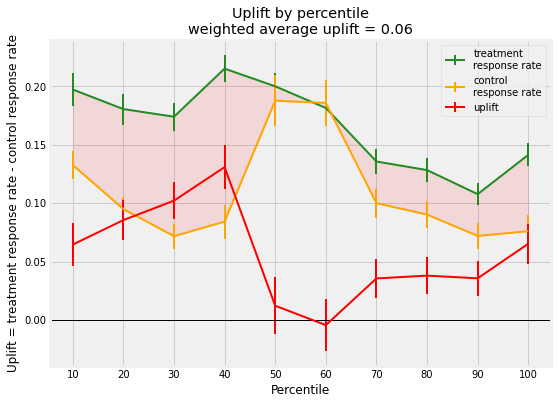

In [26]:
plot_uplift_by_percentile(y_test, uplift_sm, treat_test, strategy='overall', kind='line');

**Uplift curve**

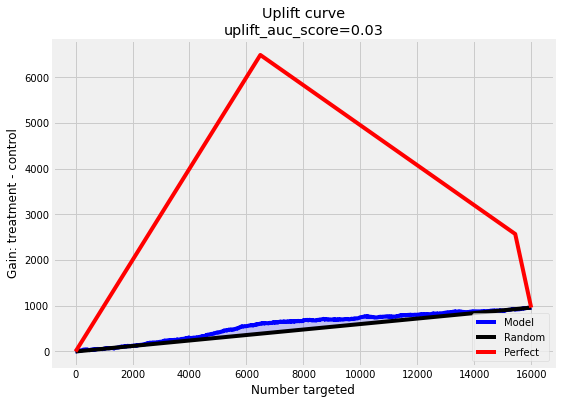

In [29]:
# with ideal curve
# perfect=True
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=True);

In [36]:
# AUUQ = area under uplift curve
auuc = uplift_auc_score(y_test, uplift_sm, treat_test) 
print(f"Uplift auc score on full data: {auuc:.4f}")

Uplift auc score on full data: 0.0257


**Qini curve**

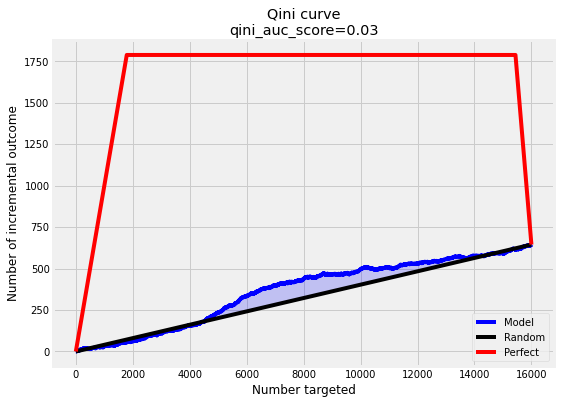

In [32]:
# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_test, uplift_sm, treat_test, perfect=True);

In [35]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_sm, treat_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0300


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [22]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

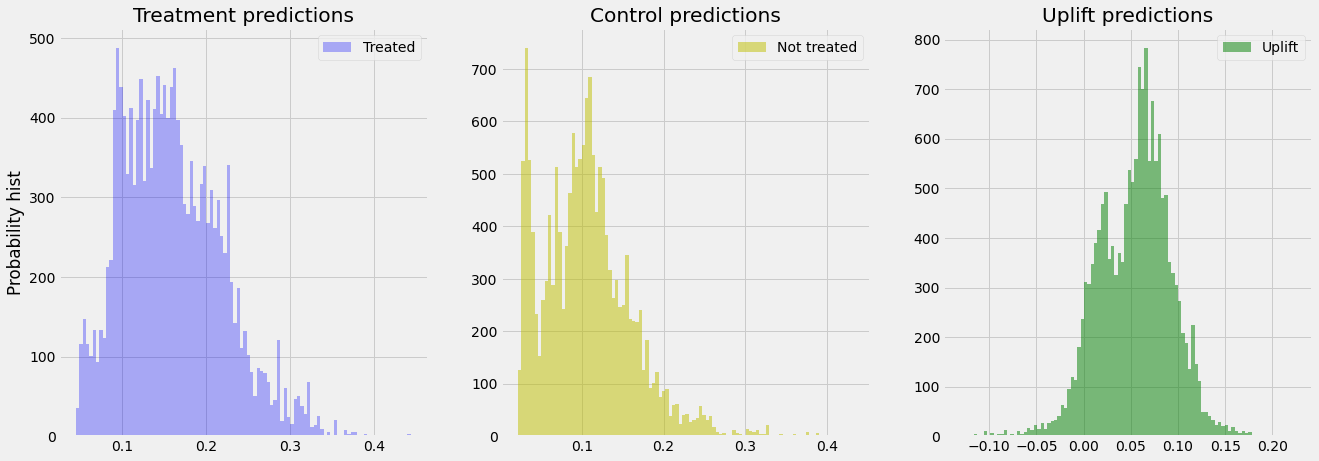

In [23]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [24]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%,uplift@30%
2,TwoModels,0.132673,0.121131,0.114414
0,SoloModel,0.057679,0.047999,0.073703
1,ClassTransformation,-0.021468,0.020978,0.016724


В этом кейсе подход TwoModels оказался гораздо лучше других. Что интересно, ClassTransformation на uplift@10% показала отрицательный результат. Почему так получилось мне не понятно.

#### Вариант с деревом решений

In [25]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,was_offer_used,median_history_purchases_on_zip_code,median_history_purchases_on_offer_used,history_on_recency_duration
0,10,142.44,1,0,Surburban,0,Phone,1,0,not_used,155.52,146.115,14.244000
1,6,329.08,1,1,Rural,1,Web,0,0,not_used,159.58,146.115,54.846667
2,7,180.65,0,1,Surburban,1,Web,1,0,used,155.52,183.845,25.807143
3,9,675.83,1,0,Rural,1,Web,1,0,used,159.58,183.845,75.092222
4,2,45.34,1,0,Urban,0,Web,1,0,not_used,160.28,146.115,22.670000


In [26]:
X_train_tree = pd.concat([X_train.drop('was_offer_used', 1), 
                          pd.get_dummies(X_train['was_offer_used'], prefix='was_offer_used'),
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'),
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

In [27]:
%%time

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

CPU times: user 15.1 s, sys: 217 ms, total: 15.3 s
Wall time: 15.3 s


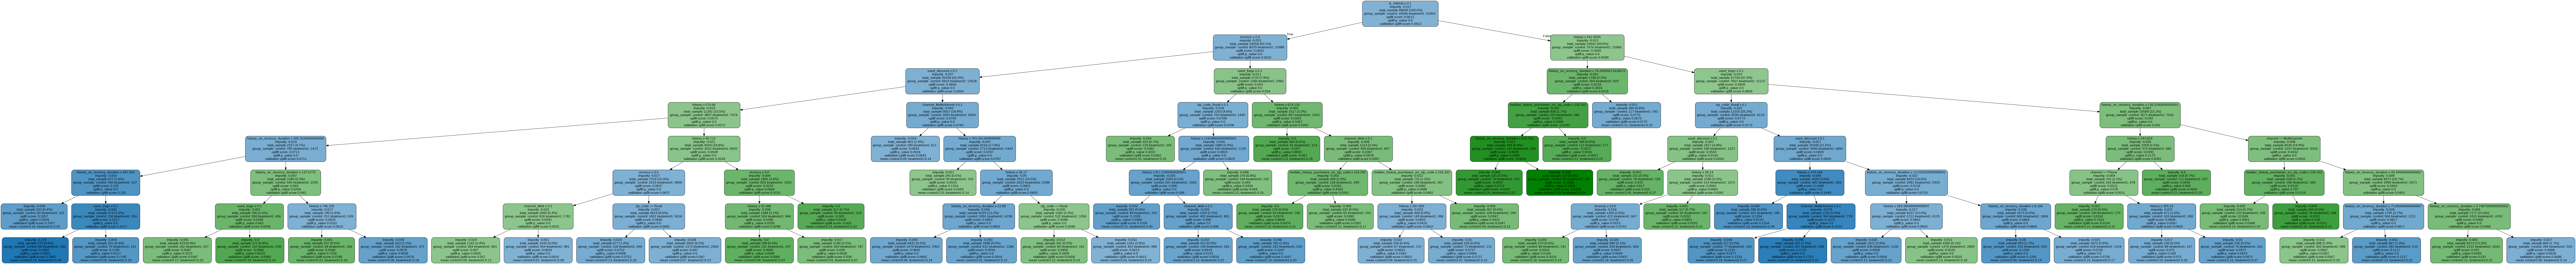

In [28]:
Image(graph.create_png())

Можно отметить что у дерева получилось на некоторых листах достичь высокий uplift до 0.19, а где-то наоборот отрицательный. Но нужно проверять, не переобучилось ли оно. 

Визуально кажется, что фича 'is_referal' влияет больше всего на результат. Это видно по тому, что по ней разделяются ветви в самом начале. Ранее в ноутбуке мы выводили важность фич с помощью метода feature_importances_ и он это подтверждает.